In [0]:
!pip3 install -q http://download.pytorch.org/whl/cu90/torch-0.4.0-cp36-cp36m-linux_x86_64.whl
!pip3 install torchvision

**Library import**

In [0]:
%matplotlib inline
import torch
import torchvision
from torchvision import models
import torchvision.transforms as transforms
from torchvision.transforms import ToPILImage
import torch.optim as optim
from IPython.display import Javascript

import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt

import numpy as np

**Definition of functions for dispay**

In [0]:
# function to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
def plot_kernel(model):
    model_weights = model.state_dict()
    fig = plt.figure()
    plt.figure(figsize=(10,10))
    for idx, filt  in enumerate(model_weights['conv1.weight']):
    #print(filt[0, :, :])
        if idx >= 32: continue
        plt.subplot(4,8, idx + 1)
        plt.imshow(filt[0, :, :], cmap="gray")
        plt.axis('off')
    
    plt.show()

def plot_kernel_output(model,images):
    fig1 = plt.figure()
    plt.figure(figsize=(1,1))
    
    img_normalized = (images[0] - images[0].min()) / (images[0].max() - images[0].min())
    plt.imshow(img_normalized.numpy().transpose(1,2,0))
    plt.show()
    output = model.conv1(images)
    layer_1 = output[0, :, :, :]
    layer_1 = layer_1.data

    fig = plt.figure()
    plt.figure(figsize=(10,10))
    for idx, filt  in enumerate(layer_1):
        if idx >= 32: continue
        plt.subplot(4,8, idx + 1)
        plt.imshow(filt, cmap="gray")
        plt.axis('off')
    plt.show() 

**Test Accuracy Function**

In [0]:
def test_accuracy(net, dataloader):
  
    #check accuracy on whole test set
    correct = 0
    total = 0
    net.eval() #important for deactivating dropout and correctly use batchnorm accumulated statistics
    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            images = images.cuda()
            labels = labels.cuda()
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print('Accuracy of the network on the test set: %d %%' % (
    accuracy))
    return accuracy

**Number of Classes**


Since we are using the CIFAR 100, the number of classes in 100

In [0]:
n_classes = 100 

# Traditional Neural Network

In this section we are going to train a **multilayer perceptron network. **


To begin we define the class for the network. It consists of two hidden layers and a last FC layer network of 100 classes. 


In [0]:
# function to define an old style fully connected network (multilayer perceptrons)
class old_nn(nn.Module):
    def __init__(self):
        super(old_nn, self).__init__()
        self.fc1 = nn.Linear(32*32*3, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, n_classes) #last FC for classification 

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = F.sigmoid(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        x = self.fc3(x)
        return x

The first part of the code is related to loading the data and providing training and testing sets. It deals with all the resizingm transformations, data augmentation... Here we don't use data augmentation techniques.


In [0]:
#transform are heavily used to do simple and complex transformation and data augmentation
transform_train = transforms.Compose(
    [
     #transforms.RandomHorizontalFlip(),
     transforms.Resize((32,32)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

transform_test = transforms.Compose(
    [
     transforms.Resize((32,32)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
     ])

trainset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=256,
                                          shuffle=True, num_workers=4,drop_last=True)

testset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=256,
                                         shuffle=False, num_workers=4,drop_last=True)

dataiter = iter(trainloader)

Now we create an old style NN and we train

In [0]:
net = old_nn()
net = net.cuda()

criterion = nn.CrossEntropyLoss().cuda() #it already does softmax computation for use!
optimizer = optim.Adam(net.parameters(), lr=0.0001) #better convergency w.r.t simple SGD :)

########TRAINING PHASE###########
n_loss_print = len(trainloader)  #print every epoch, use smaller numbers if you wanna print loss more often!

n_epochs = 20

lossPlot=[]
accPlot=[]

for epoch in range(n_epochs):  # loop over the dataset multiple times
    net.train() #important for activating dropout and correctly train batchnorm
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs and cast them into cuda wrapper
        inputs, labels = data
        inputs = inputs.cuda()
        labels = labels.cuda()
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % n_loss_print == (n_loss_print -1):    
            temp=running_loss / n_loss_print
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, temp))
            lossPlot.append(temp)
            running_loss = 0.0
    accPlot.append(test_accuracy(net,testloader))
      
print('Finished Training')


Now we plot the Loss curve

<function matplotlib.pyplot.show>

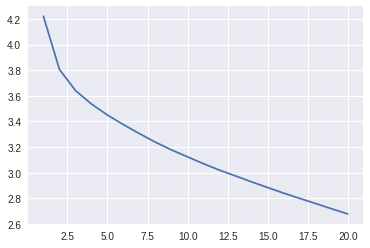

In [0]:
plt.plot(range(1,len(lossPlot)+1),lossPlot)
plt.show

And the accuracy curve

<function matplotlib.pyplot.show>

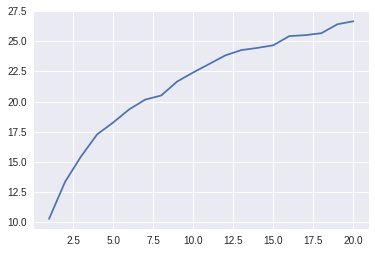

In [0]:
plt.plot(range(1,len(accPlot)+1),accPlot)
plt.show

## Comments

The accuracy is low as expected. Looking deeper into the given dataset, I would like to point out some point. 

First of all this dataset contains images which are RGB (x3 the data) . Also, images vary alot, so the amount of feature would be huge. We would need a deeper NN.

# Convolutional Neural Networks

Let us use the CNN given.

In [0]:
#function to define the convolutional network
class CNN(nn.Module):
    def __init__(self,s1=32,s2=32,s3=32,s4=64,o=4096):
        super(CNN, self).__init__()
        #conv2d first parameter is the number of kernels at input (you get it from the output value of the previous layer)
        #conv2d second parameter is the number of kernels you wanna have in your convolution, so it will be the n. of kernels at output.
        #conv2d third, fourth and fifth parameters are, as you can read, kernel_size, stride and zero padding :)
        self.conv1 = nn.Conv2d(3, s1, kernel_size=5, stride=2, padding=0)
        self.conv2 = nn.Conv2d(s1, s2, kernel_size=3, stride=1, padding=0)
        self.conv3 = nn.Conv2d(s2, s3, kernel_size=3, stride=1, padding=0)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv_final = nn.Conv2d(s3, s4, kernel_size=3, stride=1, padding=0)
        self.fc1 = nn.Linear(s4 * 4 * 4, o)
        self.fc2 = nn.Linear(o, n_classes) #last FC for classification 

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.pool(self.conv_final(x)))
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        #hint: dropout goes here!
        x = self.fc2(x)
        return x


We now define the CNN

In [0]:
net = CNN()

And train

In [0]:
net = net.cuda()

criterion = nn.CrossEntropyLoss().cuda() #it already does softmax computation for use!
optimizer = optim.Adam(net.parameters(), lr=0.0001) #better convergency w.r.t simple SGD :)

########TRAINING PHASE###########
n_loss_print = len(trainloader)  #print every epoch, use smaller numbers if you wanna print loss more often!

n_epochs = 20

lossPlot=[]
accPlot=[]

for epoch in range(n_epochs):  # loop over the dataset multiple times
    net.train() #important for activating dropout and correctly train batchnorm
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs and cast them into cuda wrapper
        inputs, labels = data
        inputs = inputs.cuda()
        labels = labels.cuda()
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % n_loss_print == (n_loss_print -1):    
            temp=running_loss / n_loss_print
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, temp))
            lossPlot.append(temp)
            running_loss = 0.0
    accPlot.append(test_accuracy(net,testloader))
      
print('Finished Training')


Now we plot the Loss curve

<function matplotlib.pyplot.show>

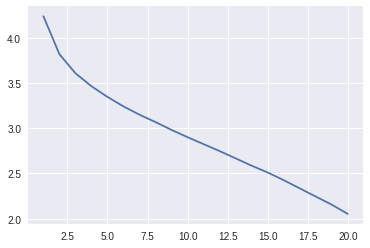

In [0]:
plt.plot(range(1,len(lossPlot)+1),lossPlot)
plt.show

And the accuracy curve

<function matplotlib.pyplot.show>

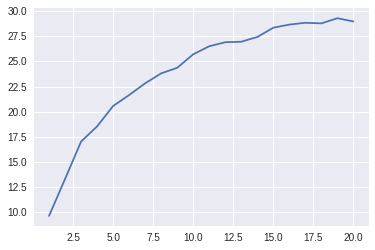

In [0]:
plt.plot(range(1,len(accPlot)+1),accPlot)
plt.show

## Comments

Even though the number of parameters to train required in CNN is less than that of a MLP, the accuracy is a little bit better than that of the MLP. With the high number of features it has to learn (noting that there are 100 classes), and considering the architecture of the following CNN, the accuracy, even a little bit low, could be expected



# More CNNs

##128/128/128/256

We change the number of convolutional filters to 128/128/128/256

In [0]:
net=CNN(128,128,128,256)

We train the network same way as we did above.

We plot the Loss curve

<function matplotlib.pyplot.show>

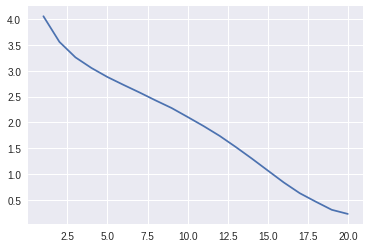

In [0]:
plt.plot(range(1,len(lossPlot)+1),lossPlot)
plt.show

.

.

.

.

.

And the accuracy curve

<function matplotlib.pyplot.show>

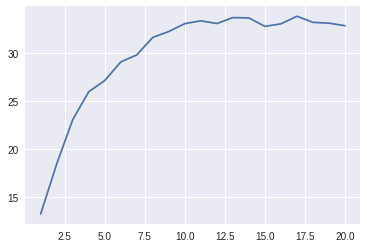

In [0]:
plt.plot(range(1,len(accPlot)+1),accPlot)
plt.show

**The time required here was 386.719 s**

##256/256/256/512

We change the number of convolutional filters to 256/256/256/512


In [0]:
net=CNN(256,256,256,512)

We train the network same way as we did above.

We plot the Loss curve

<function matplotlib.pyplot.show>

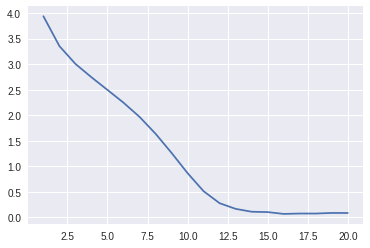

In [0]:
plt.plot(range(1,len(lossPlot)+1),lossPlot)
plt.show

And the accuracy curve

<function matplotlib.pyplot.show>

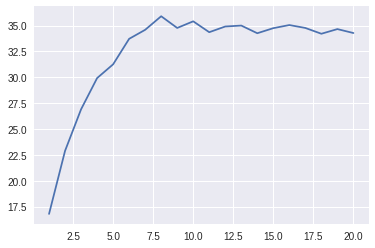

In [0]:
plt.plot(range(1,len(accPlot)+1),accPlot)
plt.show

**The time required here was 857.179 s**



##512/512/512/1024

We change the number of convolutional filters to 512/512/512/1024



In [0]:
net=CNN(512,512,512,1024)

We train the network same way as we did above.

We plot the Loss curve

<function matplotlib.pyplot.show>

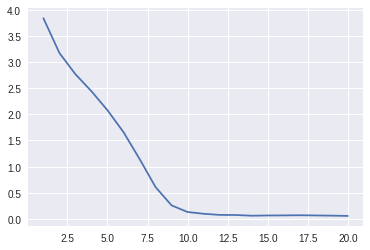

In [0]:
plt.plot(range(1,len(lossPlot)+1),lossPlot)
plt.show

And the accuracy curve

<function matplotlib.pyplot.show>

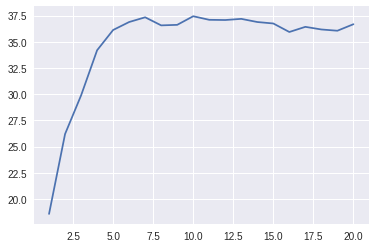

In [0]:
plt.plot(range(1,len(accPlot)+1),accPlot)
plt.show

**The time required here was 2606.918 s**

## Comments

We notice that at the end, the final accuracy is around 7% more than that of the starting one. But this accuracy isn't so much better than that of the previous cases and it takes more time than the previous cases (As we double the number the time required increases more than the double).


But what is interesting is that the rate, at which the accuracy increases (loss decreases), increases with the increase in number of convolutional filters.

Another thing to notice is that the value is always stuck in the 35% range. This could be solved by decreasing the learning rate. If that doesn't work, we should probably think about changing our architecture since our network isn't able to generalize on the test set.

It would be good to have a validation set and seeing the loss for the validation also.




# Even More CNNS

Here we will use the network with 128/128/128/256 filters

##Batch Normalization


The CNN class is updated to take into consideration batch normalization

In [0]:
#function to define the convolutional network with normalization and dropout
class CNN(nn.Module):
    def __init__(self,s1=32,s2=32,s3=32,s4=64,o=4096,BN=False,DO=False):
        super(CNN, self).__init__()
        #conv2d first parameter is the number of kernels at input (you get it from the output value of the previous layer)
        #conv2d second parameter is the number of kernels you wanna have in your convolution, so it will be the n. of kernels at output.
        #conv2d third, fourth and fifth parameters are, as you can read, kernel_size, stride and zero padding :)
        self.conv1 = nn.Conv2d(3, s1, kernel_size=5, stride=2, padding=0)
        self.conv1_bn = nn.BatchNorm2d(s1)
        self.conv2 = nn.Conv2d(s1, s2, kernel_size=3, stride=1, padding=0)
        self.conv2_bn = nn.BatchNorm2d(s2)
        self.conv3 = nn.Conv2d(s2, s3, kernel_size=3, stride=1, padding=0)
        self.conv3_bn = nn.BatchNorm2d(s3)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv_final = nn.Conv2d(s3, s4, kernel_size=3, stride=1, padding=0)
        self.conv_final_bn = nn.BatchNorm2d(s4)
        self.fc1 = nn.Linear(s4 * 4 * 4, o)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(o, n_classes) #last FC for classification 
        self.BN=BN
        self.DO=DO
    def forward(self, x):
        if(self.BN==False):
          x = F.relu(self.conv1(x))
          x = F.relu(self.conv2(x))
          x = F.relu(self.conv3(x))
          x = F.relu(self.pool(self.conv_final(x)))
          x = x.view(x.shape[0], -1)
          x = F.relu(self.fc1(x))
        else:
          x = F.relu(self.conv1_bn(self.conv1(x)))
          x = F.relu(self.conv2_bn(self.conv2(x)))
          x = F.relu(self.conv3_bn(self.conv3(x)))
          x = F.relu(self.pool(self.conv_final_bn(self.conv_final(x))))
          x = x.view(x.shape[0], -1)
          x = F.relu(self.fc1(x))
        
        #hint: dropout goes here!
        if(self.DO):
          x = self.dropout(x)
          
        x = self.fc2(x)
        return x


We define the NN and we train

In [0]:
net = CNN(128,128,128,256,4096,BN=True,DO=False)

Now we plot the Loss curve

<function matplotlib.pyplot.show>

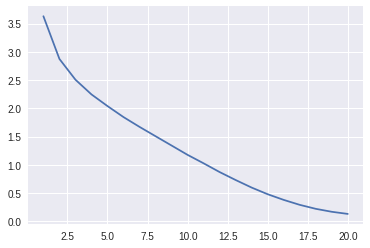

In [0]:
plt.plot(range(1,len(lossPlot)+1),lossPlot)
plt.show

And the accuracy curve

<function matplotlib.pyplot.show>

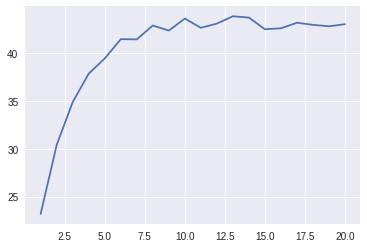

In [0]:
plt.plot(range(1,len(accPlot)+1),accPlot)
plt.show

**This required 408.545 s  and yielded 42%**

## BN with wider FC1


Here we use the batch normalization but with FC1 having 8192 neurons

In [0]:
net = CNN(128,128,128,256,8192,BN=True,DO=False)

We train the net.


The loss curve is:

<function matplotlib.pyplot.show>

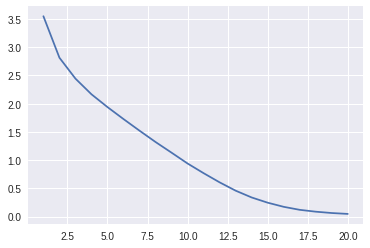

In [0]:
plt.plot(range(1,len(lossPlot)+1),lossPlot)
plt.show

And the accuracy curve

<function matplotlib.pyplot.show>

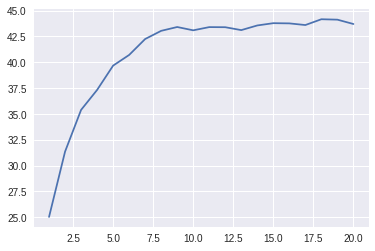

In [0]:
plt.plot(range(1,len(accPlot)+1),accPlot)
plt.show

**This required 471.075s and yielded 43% accuracy**

## BN with 0.5 DropOut on FC1 (4096)



We now activate the dropout

In [0]:
net = CNN(128,128,128,256,4096,BN=True,DO=True)

We train the net.


The loss curve is:

<function matplotlib.pyplot.show>

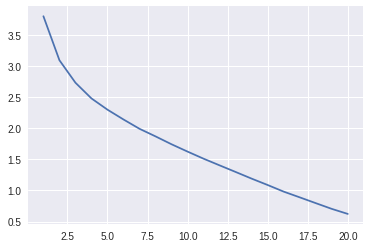

In [0]:
plt.plot(range(1,len(lossPlot)+1),lossPlot)
plt.show

And the accuracy curve

<function matplotlib.pyplot.show>

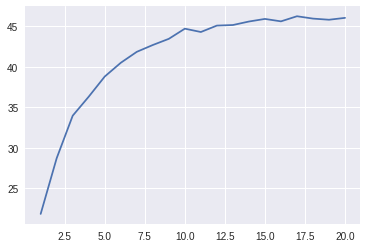

In [0]:
plt.plot(range(1,len(accPlot)+1),accPlot)
plt.show

**This required 410.319s and yielded 46% accuracy**

## Comments

As expected the accuracy when we applied BN would increase. We doubled the neurons on the output of FC1 but the computation time only increased 70s without that much increase in the accuracy. 

Meanwhile when we appied BN with dropout of 0.5, it was able to reach more accuracy with less computational time. This was expected.


We could say that inorder to increase the accuracy of a CNN, BN should be done. DropOut has helped increase the accuracy slightly. As a regualization technique, it could have solve some overfitting problem in our model. Playing with the values could help us achieve better accuracy.

Also when increasing the size of FC1 the oscillations on the accuracy at stability decreased. That was also evident in the case of dropout. 

# Data Augmentation

We update our net to the required network to the basic 128/128/128/256 without batch normalization and dropout:

In [0]:
net = CNN(128,128,128,256,4096,BN=False,DO=False)

## Random Horizontal Flip

We change the data sets to include horizontal flips

In [0]:
#transform are heavily used to do simple and complex transformation and data augmentation
transform_train = transforms.Compose(
    [
     transforms.RandomHorizontalFlip(),
     transforms.Resize((32,32)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

transform_test = transforms.Compose(
    [
     transforms.Resize((32,32)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
     ])

trainset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=256,
                                          shuffle=True, num_workers=4,drop_last=True)

testset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=256,
                                         shuffle=False, num_workers=4,drop_last=True)

dataiter = iter(trainloader)

We then train the net and we plot the loss curve:

<function matplotlib.pyplot.show>

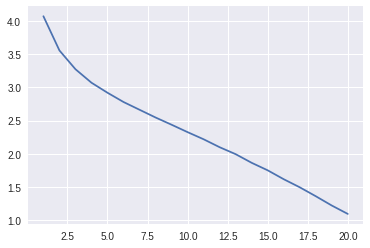

In [0]:
plt.plot(range(1,len(lossPlot)+1),lossPlot)
plt.show

And the accuracy curve

<function matplotlib.pyplot.show>

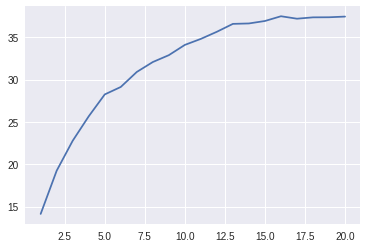

In [0]:
plt.plot(range(1,len(accPlot)+1),accPlot)
plt.show

**It took 395.366s and gave an accuracy of around 37%** (almost a 9% increase)

## Random Crops

We change the data sets now to include both horizontal flips and random crops

In [0]:
#transform are heavily used to do simple and complex transformation and data augmentation
transform_train = transforms.Compose(
    [
     transforms.RandomHorizontalFlip(),
     transforms.Resize((40,40)),
     transforms.RandomCrop((32,32)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

transform_test = transforms.Compose(
    [
     transforms.Resize((32,32)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
     ])

trainset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=256,
                                          shuffle=True, num_workers=4,drop_last=True)

testset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=256,
                                         shuffle=False, num_workers=4,drop_last=True)

dataiter = iter(trainloader)

We then train the net and we plot the loss curve:

<function matplotlib.pyplot.show>

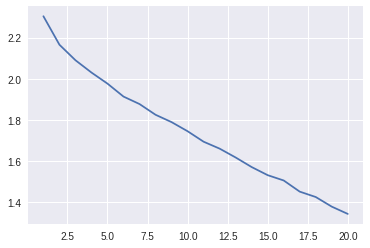

In [0]:
plt.plot(range(1,len(lossPlot)+1),lossPlot)
plt.show

And the accuracy curve

<function matplotlib.pyplot.show>

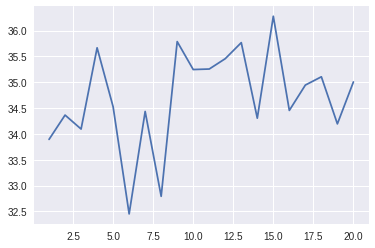

In [0]:
plt.plot(range(1,len(accPlot)+1),accPlot)
plt.show

**It took 419.092s and gave an accuracy of around 35%**. Here it is somewhat easier to learn features since there were cropped images.

## Comments

Applying these data augmentation methods have increased our accuracy around 7%, and also the accuracy rate at the beginning (33% accuracy from first epoch when both flips and crops are applied). This method along with Batch normalization and drop could help increase the accuracy of our network

# Residual Neural Network

We are required to use ResNet18 with the following parameters:

128 batch size, 10 epochs, 224x224 resolution,
Adam solver with learning rate 0.0001


We will also use data augmentation (Horizontal flips since they gave best accuracy. And since we would loss resolution from resizing 32x32 to 224x224, cropping would probably make feature extraction different). We update our dataset:


In [0]:
#transform are heavily used to do simple and complex transformation and data augmentation
transform_train = transforms.Compose(
    [
     transforms.RandomHorizontalFlip(),
     transforms.Resize((224,224)),
     #transforms.RandomCrop((224,224)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

transform_test = transforms.Compose(
    [
     transforms.Resize((224,224)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
     ])

trainset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True, num_workers=4,drop_last=True)

testset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=128,
                                         shuffle=False, num_workers=4,drop_last=True)

dataiter = iter(trainloader)

And import the ResNet

In [0]:
net = models.resnet18(pretrained=True)
net.fc = nn.Linear(512, n_classes) #changing the fully connected layer of the already allocated network

We train using the updated parameters

In [0]:
net = net.cuda()

criterion = nn.CrossEntropyLoss().cuda() #it already does softmax computation for use!
optimizer = optim.Adam(net.parameters(), lr=0.0001) #better convergency w.r.t simple SGD :)


########TRAINING PHASE###########
n_loss_print = len(trainloader)  #print every epoch, use smaller numbers if you wanna print loss more often!

n_epochs = 10

lossPlot=[]
accPlot=[]

for epoch in range(n_epochs):  # loop over the dataset multiple times
    net.train() #important for activating dropout and correctly train batchnorm
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs and cast them into cuda wrapper
        inputs, labels = data
        inputs = inputs.cuda()
        labels = labels.cuda()
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % n_loss_print == (n_loss_print -1):    
            temp=running_loss / n_loss_print
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, temp))
            lossPlot.append(temp)
            running_loss = 0.0
    accPlot.append(test_accuracy(net,testloader))
      
print('Finished Training')


We plot the Loss curve

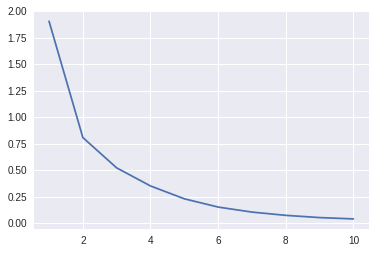

In [0]:
plt.plot(range(1,len(lossPlot)+1),lossPlot)
plt.show()

and the accuracy

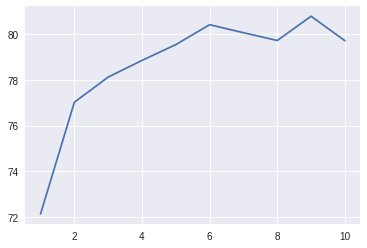

In [0]:
plt.plot(range(1,len(accPlot)+1),accPlot)
plt.show()

**The accuracy is around 80% and it took 699.921s **

## Comments

The ResNet18 provides the best accuracy. This network being pretrained for imagenet, and fined tuned for our dataset acts behaves good. Using transfer learning in training networks is a good strategy that saves us time on deep networks and could substantially provide better results. 

# Others

The folowing code has been used to save the models with best accuracy

In [0]:
#To save the file
txt=open("network.pt","wb")
torch.save(net.state_dict(), txt)
txt.close()

In [0]:
#To download the file
from google.colab import files
files.download("resnet.h5")